## Multi-label classification

In [27]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [28]:
from fastai.conv_learner import *

In [29]:
PATH = 'data/planet-understanding-the-amazon-from-space/'

In [30]:
# Data preparation steps if you are using Crestle:

#os.makedirs('data/planet/models', exist_ok=True)
#os.makedirs('/cache/planet/tmp', exist_ok=True)

#!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train-jpg {PATH}
#!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/test-jpg {PATH}
#!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train_v2.csv {PATH}
#!ln -s /cache/planet/tmp {PATH}

In [31]:
ls {PATH}

Kaggle-planet-test-tif.torrent*   test_v2_file_mapping.csv*
Kaggle-planet-train-tif.torrent*  test_v2_file_mapping.csv.zip*
sample_submission_v2.csv/         tmp/
sample_submission_v2.csv.zip*     train-jpg/
test-jpg/                         train-jpg.tar.7z*
test-jpg-additional/              train-tif-v2/
test-jpg-additional.tar.7z*       train-tif-v2.tar.7z*
test-jpg.tar.7z*                  train_v2.csv*
test-tif-v2.tar.7z*               train_v2.csv.zip*


## Multi-label versus single-label classification

In [32]:
from fastai.plots import *

In [33]:
def get_1st(path): return glob(f'{path}/*.*')[0]

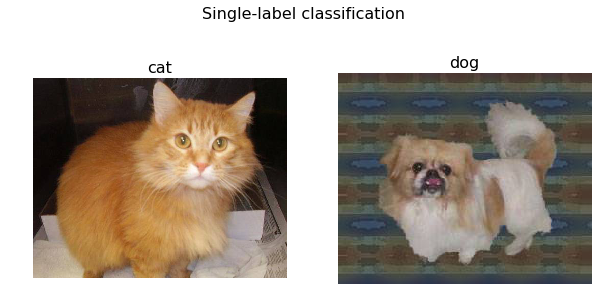

In [34]:
dc_path = "data/dogscats/valid/"
list_paths = [get_1st(f"{dc_path}cats"), get_1st(f"{dc_path}dogs")]
plots_from_files(list_paths, titles=["cat", "dog"], maintitle="Single-label classification")

In single-label classification each sample belongs to one class. In the previous example, each image is either a *dog* or a *cat*.

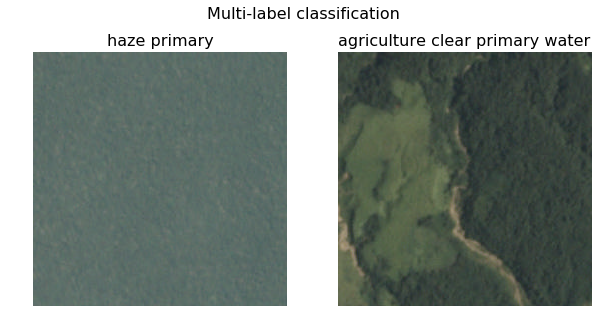

In [35]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In multi-label classification each sample can belong to one or more clases. In the previous example, the first images belongs to two clases: *haze* and *primary*. The second image belongs to four clases: *agriculture*, *clear*, *primary* and  *water*.

## Multi-label models for Planet dataset

In [36]:
from planet import f2

metrics=[f2]
f_model = resnet34

In [37]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

In [38]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [39]:
data = get_data(256)

In [40]:
x,y = next(iter(data.val_dl))

In [41]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

In [42]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

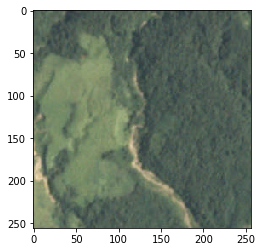

In [43]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [44]:
sz=64

In [45]:
data = get_data(sz)

In [46]:
data = data.resize(int(sz*1.3), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [47]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.213151   0.240448   0.819978  



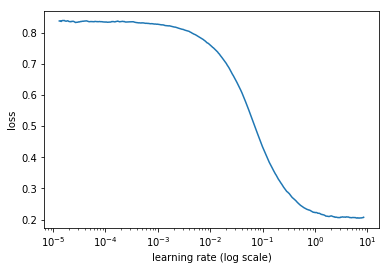

In [48]:
lrf=learn.lr_find()
learn.sched.plot()

In [49]:
lr = 0.2

In [50]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.145875   0.135105   0.879798  
    1      0.140934   0.129028   0.887676                    
    2      0.137765   0.127463   0.88856                     
    3      0.138315   0.126631   0.889457                    
    4      0.133801   0.125006   0.890908                    
    5      0.132241   0.123805   0.892786                    
    6      0.131161   0.123025   0.893443                    



[0.12302463, 0.8934425806798282]

In [51]:
lrs = np.array([lr/9,lr/3,lr])

In [52]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.123879   0.112258   0.905433  
    1      0.113821   0.10571    0.909964                    
    2      0.11185    0.102606   0.913557                    
    3      0.111209   0.105397   0.908538                    
    4      0.106713   0.10062    0.914426                    
    5      0.101097   0.098882   0.917011                     
    6      0.101114   0.097891   0.91726                      



[0.097890586, 0.9172597670777984]

In [53]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
                           ('output_shape', [-1, 64, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 16, 16]),
          

In [54]:
learn.save(f'{sz}')

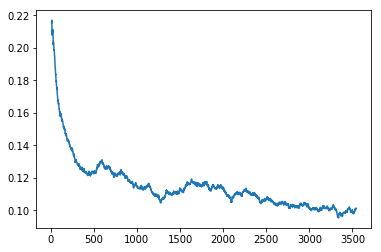

In [55]:
learn.sched.plot_loss()

In [56]:
sz=128

In [21]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.09729  0.09375  0.91885]                         
[ 1.       0.10118  0.09243  0.92075]                         
[ 2.       0.09805  0.09143  0.92235]                         
[ 3.       0.09834  0.09134  0.92263]                         
[ 4.       0.096    0.09046  0.9231 ]                         
[ 5.       0.09584  0.09035  0.92403]                         
[ 6.       0.09262  0.09059  0.92358]                         



In [22]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

A Jupyter Widget

[ 0.       0.09623  0.08693  0.92696]                         
[ 1.       0.09371  0.08621  0.92887]                         
[ 2.       0.08919  0.08296  0.93113]                         
[ 3.       0.09221  0.08579  0.92709]                         
[ 4.       0.08994  0.08575  0.92862]                         
[ 5.       0.08729  0.08248  0.93108]                         
[ 6.       0.08218  0.08315  0.92971]                         



In [23]:
sz=256

In [24]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.09161  0.08651  0.92712]                         
[ 1.       0.08933  0.08665  0.92677]                         
[ 2.       0.09125  0.08584  0.92719]                         
[ 3.       0.08732  0.08532  0.92812]                         
[ 4.       0.08736  0.08479  0.92854]                         
[ 5.       0.08807  0.08471  0.92835]                         
[ 6.       0.08942  0.08448  0.9289 ]                         



In [25]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

A Jupyter Widget

[ 0.       0.08932  0.08218  0.9324 ]                         
[ 1.       0.08654  0.08195  0.93313]                         
[ 2.       0.08468  0.08024  0.93391]                         
[ 3.       0.08596  0.08141  0.93287]                         
[ 4.       0.08211  0.08152  0.93401]                         
[ 5.       0.07971  0.08001  0.93377]                         
[ 6.       0.07928  0.0792   0.93554]                         



In [26]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [27]:
f2(preds,y)

0.93626519738612801

### End